### we will start by patching our notebook to be optimized to run with intel-based CPUs 
### by doing that we can make our sklearn models run much faster, and as we are dealing with a large data set it is very important 
### it is a good way to prevent Kernel crushes by reducing ram usage 

In [44]:
from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### importing needed libaries 

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
%matplotlib inline

### importing our data and cleaning the data 
### cleaning the data includes turning any categorical data into numerical data to use with regression models 

In [46]:
df = pd.read_csv('/Users/dimagoroh/Desktop/data_vis/big_file.csv', low_memory=False)

In [47]:
df=df.drop(['downloadSpeed', 'uploadSpeed'], axis=1)
df = df.dropna()

In [48]:
df["time"] = df['date'].astype(str) + " " +df["hour"]

In [49]:
df['time'] = pd.to_datetime(df["time"])
df['hour']=df['time'].dt.hour
df['minute']=df['time'].dt.minute
df['hour']=df['time'].dt.hour
df['second']=df['time'].dt.second
df['month']=df['time'].dt.month
df['day']=df['time'].dt.day
df['postal_code'] = df['postal_code'].astype(str)
df['region_code'] = df['postal_code'].str[:1]


conditions = [
    (df['region_code'] == "8"),
    (df['region_code'] == "1"),
     (df['region_code'] == "2"),
    (df['region_code'] == "4") 
]

values = ['Barcelona','Girona','Lleida','Tarragona']

df['region_code'] = np.select(conditions, values)


In [128]:
df=df[df['speed'] >0] 
### checking our data correlation 

cols = ['speed'] 
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8779106 entries, 0 to 11744913
Data columns (total 25 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           object        
 1   hour           int64         
 2   lat            float64       
 3   long           float64       
 4   signal         int64         
 5   network        object        
 6   operator       object        
 7   status         int64         
 8   description    object        
 9   net            object        
 10  speed          float64       
 11  satellites     float64       
 12  precission     float64       
 13  provider       object        
 14  activity       object        
 15  postal_code    object        
 16  town_name      object        
 17  position_geom  object        
 18  row_num        int64         
 19  time           datetime64[ns]
 20  minute         int64         
 21  second         int64         
 22  month          int64         
 23  day   

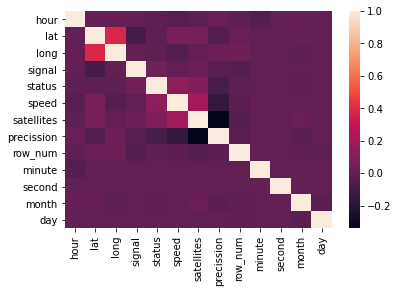

In [130]:
sns.heatmap(df.corr());

### choosing a network to predict  

In [131]:

df.groupby(['network'])['network'].count().sort_values(ascending=False).head(10)
filtered_df = df[df['network'] == 'yoigo'] 

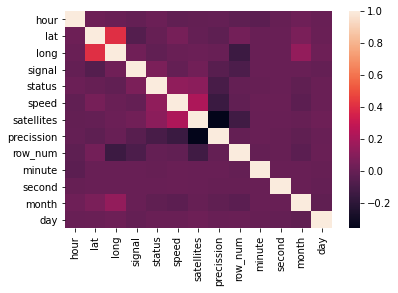

In [132]:
sns.heatmap(filtered_df.corr());


In [133]:
filtered_df["time"] = pd.to_numeric(filtered_df["time"], downcast="float")
filtered_df=filtered_df.drop(['date'], axis=1)
filtered_df=filtered_df.drop(['row_num'], axis=1)
#filtered_df=filtered_df.drop(['town_name'], axis=1)
filtered_df=filtered_df.drop(['description','operator'], axis=1)
filtered_df=filtered_df.drop(['position_geom'], axis=1)
filtered_df.info()

<ipython-input-133-6c15a3517b7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_numeric(filtered_df["time"], downcast="float")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 295699 entries, 31 to 11744768
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   hour         295699 non-null  int64  
 1   lat          295699 non-null  float64
 2   long         295699 non-null  float64
 3   signal       295699 non-null  int64  
 4   network      295699 non-null  object 
 5   status       295699 non-null  int64  
 6   net          295699 non-null  object 
 7   speed        295699 non-null  float64
 8   satellites   295699 non-null  float64
 9   precission   295699 non-null  float64
 10  provider     295699 non-null  object 
 11  activity     295699 non-null  object 
 12  postal_code  295699 non-null  object 
 13  town_name    295699 non-null  object 
 14  time         295699 non-null  float32
 15  minute       295699 non-null  int64  
 16  second       295699 non-null  int64  
 17  month        295699 non-null  int64  
 18  day          295699 n

In [134]:
#filtered_df=filtered_df.drop(['second','minute','postal_code'], axis=1)
filtered_df=filtered_df.drop(['second','minute'], axis=1)

### creating dummies for our categorical variables  

In [135]:
categorical = ['net','provider','activity','region_code','town_name']


In [136]:
df_dummies = pd.get_dummies(filtered_df, columns=categorical)

In [137]:
filtered_df=df_dummies

In [138]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295699 entries, 31 to 11744768
Columns: 721 entries, hour to town_name_Òdena
dtypes: float32(1), float64(5), int64(5), object(2), uint8(708)
memory usage: 230.1+ MB


In [139]:
filtered_df.shape

(295699, 721)

### preparing our data to test and train 

In [196]:


x= filtered_df.drop(['speed','network','time'],axis=1)
y=filtered_df['speed']
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=101)

In [197]:
#y_train = df_train['speed']
#y_test = df_test['speed']



# <b>choosing the correct algoritem </b>
## <b>Linear Regression is very easy and fast to implement but-
### it Assumes linear relationship between dependent and independent variables, which is incorrect in most cases and especialy as we saw from the heat map at our data set 
### Sensitive to outliers
### If the number of observations are less, it leads to over fitting, it starts considering noise.

## <b>Ridge Regression-</b>
### Trades variance for bias (i.e. in presence of co-linearity, it is worth to have biased results, in order to lower the variance.)
### Prevents over fitting

## <b>LASSO Regression-</b>
### Selected features will be highly biased.
### For n<<p (n-number of data points, p-number of features), LASSO selects at most n features.
### LASSO will select only one feature from a group of correlated features, the selection is arbitrary in nature.
### For different boot strapped data, the feature selected can be very different.
### Prediction performance is worse than Ridge regression.

## <b>Elastic Net Regression-</b>
### Computationally more expensive than LASSO or Ridge.


# Ridge  

In [198]:
# make a prediction with a ridge regression model on the dataset
from sklearn.linear_model import Ridge
# define model
model = Ridge(alpha=0.01)
# fit model
model.fit(x_train,y_train)


Ridge(alpha=0.01)

In [199]:
coeff_df_Ridge = pd.DataFrame(model.coef_,x.columns,columns=['Coefficient']).head(60)
coeff_df_Ridge

,Coefficient
hour,-0.051184
lat,-11.168131
long,4.618215
signal,0.031915
status,1.958059
satellites,0.455382
precission,-0.042568
postal_code,-0.000025
month,-0.085111
day,-0.019245


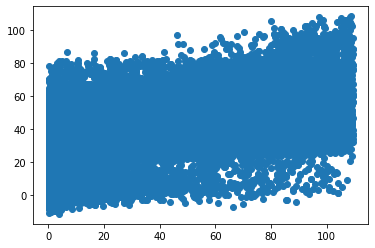

In [200]:
predictions = model.predict(x_test)
plt.scatter(y_test,predictions)

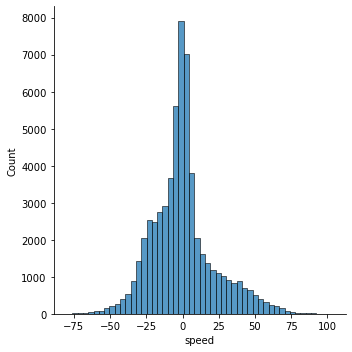

In [201]:
sns.displot((y_test-predictions),bins=50);

In [202]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2:', metrics.explained_variance_score(y_test, predictions))

MAE: 15.489863474413225
MSE: 466.90982833959356
RMSE: 21.60809636084571
R^2: 0.5156559968711176


### picking the best alpha value

In [165]:
from sklearn.metrics import r2_score

def train_eval(alpha):
    model=Ridge(alpha=alpha)
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    r2 = r2_score(y_test, predictions)
    var_score = metrics.explained_variance_score(y_test, predictions)
    return r2, var_score

for alpha in [0.0001, 0.05, 0.2, 0.3, 0.4]:
    r2, var_score = train_eval(alpha)
    print(f'r2: {r2}')
    print(f'var_score:{var_score}')

r2: 0.5178744548717844
var_score:0.517879871110601
r2: 0.517879156400541
var_score:0.5178845675675633
r2: 0.5178882107865838
var_score:0.5178936117839806
r2: 0.5178909005135466
var_score:0.5178962976925547
r2: 0.5178914936765975
var_score:0.5178968885967417


# Lasso

In [203]:
y_train.shape, y_test.shape

((236559,), (59140,))

In [204]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [205]:
lasso=Lasso(alpha=0.001)
lasso.fit(x_train,y_train)
print(lasso.intercept_)

308.6576755378919


In [206]:
coeff_df = pd.DataFrame(lasso.coef_,x.columns,columns=['Coefficient'])
coeff_df

,Coefficient
hour,-0.048106
lat,-6.992674
long,3.061840
signal,0.034378
status,2.028947
...,...
town_name_les Oluges,0.000000
town_name_les Planes d'Hostoles,0.000000
town_name_les Preses,-12.618162
town_name_les Valls de Valira,0.000000


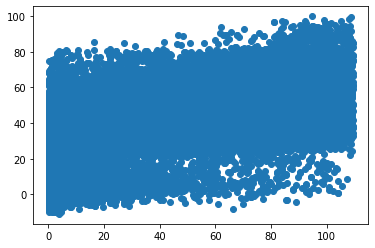

In [207]:
predictions = lasso.predict(x_test)
plt.scatter(y_test,predictions)

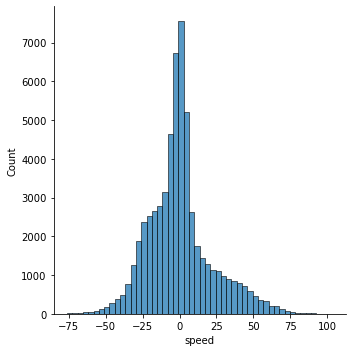

In [208]:
sns.displot((y_test-predictions),bins=50);


In [209]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2:', metrics.explained_variance_score(y_test, predictions))

MAE: 15.649644263612483
MSE: 470.1058443178264
RMSE: 21.68192436841865
R^2: 0.5123395129003689


In [210]:
#checking for the best alpha
from sklearn.metrics import r2_score

def train_eval(alpha):
    lasso=Lasso(alpha=alpha)
    lasso.fit(x_train,y_train)
    predictions = lasso.predict(x_test)
    r2 = r2_score(y_test, predictions)
    var_score = metrics.explained_variance_score(y_test, predictions)
    return r2, var_score

for alpha in [0.001, 0.05, 0.2, 0.3, 0.4]:
    r2, var_score = train_eval(alpha)
    print(f'r2: {r2}')
    print(f'var_score:{var_score}')
    

r2: 0.5123364200966503
var_score:0.5123395129003689
r2: 0.4259788049502483
var_score:0.42597909170684956
r2: 0.3847773922246127
var_score:0.3847776052924695
r2: 0.37733630961646514
var_score:0.3773365159165234
r2: 0.3752830741441405
var_score:0.3752834318285023


# ElasticNet

In [211]:
from sklearn.linear_model import ElasticNet
# define model
model = ElasticNet(alpha=0.001, l1_ratio=0.1)
# fit model
model.fit(x_train,y_train)

ElasticNet(alpha=0.001, l1_ratio=0.1)

In [212]:
print(model.intercept_)

-13.17588680968743


In [213]:
coeff_df = pd.DataFrame(model.coef_,x.columns,columns=['Coefficient'])
coeff_df

,Coefficient
hour,-0.047389
lat,0.924755
long,-1.138741
signal,0.037103
status,2.390050
...,...
town_name_les Oluges,0.620130
town_name_les Planes d'Hostoles,0.525474
town_name_les Preses,-4.771688
town_name_les Valls de Valira,0.329163


MAE: 16.40772657175058
MSE: 493.07756083129834
RMSE: 22.205349824564763
R^2: 0.4885084447983241


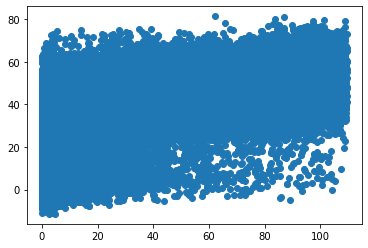

In [214]:
predictions = model.predict(x_test)
plt.scatter(y_test,predictions)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2:', metrics.explained_variance_score(y_test, predictions))

In [215]:
#gering the mean to compare to RMSE
filtered_df["speed"].mean()

25.25494404783015

0


# comparing our models 
## Ridge
### MAE: 15.491869620394237
### MSE: 464.7662246722964
### RMSE: 21.558437435776657
### R^2: 0.5178808815328103

## lasso
### MAE: 15.648825092071503
### MSE: 467.98026617099214
### RMSE: 21.63285154969155
### R^2: 0.5145456304118439

## ElasticNet
### MAE: 16.398325236926862
### MSE: 491.35424614077436
### RMSE: 22.166511817170836
### R^2: 0.4902968752609219

### we can see that our models performed similarly but Ridge has a slightly better R^2 value which means the model is slightly more accurate
### MAE gives us the error's value from the true values of the model but is sensitive to outliers and extreme values Ridge has better MAE, but because it is susceptive to outliers
### we need to look at RMSE as well
### a better parameter would be to use RMSE which is the square of mse it is less sensitive to large outliers in the data and Ridge has better RMSE  as well


# FINDINGS 

### we will look at features that have a numeric value and have business sense 
### as we thought the time value has a negative impact on speed as we saw, so as we go later in the day the speed becomes lower.
### the least impact feature is the signal, which is very surprising. one would expect that as the signal becomes better so would the speed 
### we can see that the bigest inpact is satelites.
### I would still recommend Catalonia to invest in developing its 4G infrastructure and moving to faster ones like 5G which will release the congestion on 4g networks 
###  but from the finding, i would recommend Catalonia to presure or incentive the providers to create better satellite coverage 


# mising features 

### *I would definitely add the population size of each town 
### *number of cell antennas in each town 
### *the response time to each measurement which might be an added value for speed calculation 
### *a more in dept regional division of the data 
### *network load at the time of the measurement

#  predicts the network status
### SVM works relatively well when there is a clear margin of separation between classes
### SVM is relatively memory efficient
### as we can see our accuracy to the model is good 
### note: we would have to adjust the algorithm or the feature amount if the data set would be any bigger 

In [319]:
conditions = [
    (filtered_df['status'] == 0),
    (filtered_df['status'] == 1),
    (filtered_df['status'] == 2),
    (filtered_df['status'] == 3) 
]

values = ['STATE_IN_SERVICE','STATE_OUT_OF_SERVICE','STATE_EMERGENCY_ONLY','STATE_POWER_OFF']

filtered_df['status_des'] = np.select(conditions, values)

In [320]:
filtered_df.columns

Index(['hour', 'lat', 'long', 'signal', 'network', 'status', 'speed',
       'satellites', 'precission', 'postal_code',
       ...
       'town_name_les Franqueses del Vallès', 'town_name_les Llosses',
       'town_name_les Masies de Roda', 'town_name_les Masies de Voltregà',
       'town_name_les Oluges', 'town_name_les Planes d'Hostoles',
       'town_name_les Preses', 'town_name_les Valls de Valira',
       'town_name_Òdena', 'status_des'],
      dtype='object', length=728)

In [324]:
fetures=[ 'hour', 'lat', 'long', 'signal',
       'satellites', 'precission', 'month', 'net_2G', 'net_3G','net_4G', 'provider_network',
       'provider_fused', 'provider_gps', 'activity_IN_VEHICLE',
       'activity_ON_BICYCLE', 'activity_ON_FOOT', 'activity_STILL',
       'activity_TILTING', 'activity_UNKNOWN', 'region_code_Barcelona',
       'region_code_Girona', 'region_code_Lleida', 'region_code_Tarragona']
target=['status_des']

df_train, df_test = train_test_split(filtered_df, test_size=0.2)
df_train=df_train[fetures+target]
df_test=df_test[fetures+target]
X_train = df_train[fetures].to_numpy()
X_test = df_test[fetures].to_numpy()
X_test.shape, X_train.shape

y_train = df_train['status_des']
y_test = df_test['status_des']


In [ ]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
  
# model accuracy for X_test  
accuracy = svm_model_linear.score(X_test, y_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

In [112]:
from sklearn import svm
clf = svm.SVC(kernel='linear') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9022920254141678
